<a href="https://colab.research.google.com/github/ikanx101/G-Colab/blob/main/Finding_best_hub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
#system("sudo apt-get install libglpk-dev")
#install.packages("ROI")
#install.packages("ompr")
#install.packages("ompr.roi")
#install.packages("ROI.plugin.glpk")

In [62]:
library(dplyr)
library(ompr)
library(ompr.roi)
library(ROI.plugin.glpk)
library(ggplot2)

rm(list=ls())

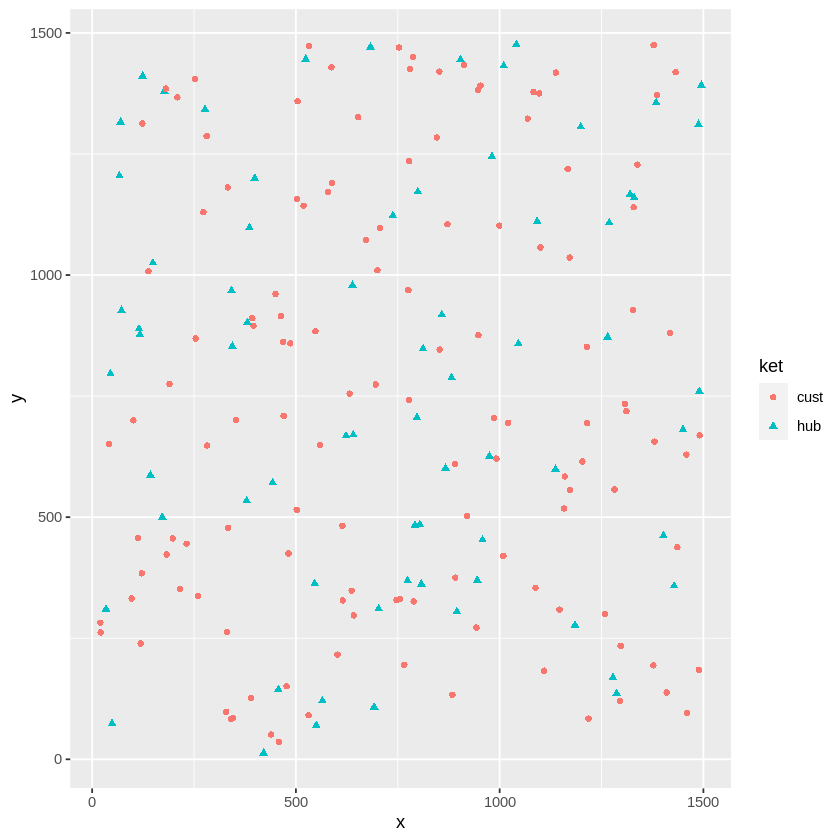

In [63]:
# create data dulu
jarak = 1500
titik = 200
toko = 70

data = data.frame(
  x = sample(jarak,titik),
  y = sample(jarak,titik),
  ket = c(rep("hub",toko),rep("cust",titik-toko))
)

data = 
  data %>%
  rowwise %>%
  mutate(cost_setup = ifelse(ket == "hub",
                             sample(30:45,1)*10,
                             NA)
        ) %>%
  ungroup()

data %>%
  ggplot(aes(x,y)) +
  geom_point(aes(color = ket,shape = ket))

In [64]:
head(data)

x,y,ket,cost_setup
<int>,<int>,<chr>,<dbl>
381,902,hub,310
683,1471,hub,440
774,369,hub,370
808,362,hub,330
1092,1111,hub,360
867,601,hub,370


In [65]:
cost_deli = function(idx_1,idx_2){
  cust_ = cust_data[idx_1,]
  hub_ = hub_data[idx_2,]
  jarak = sqrt((cust_$x - hub_$x)^2 + (cust_$y - hub_$y)^2)
  jarak = round(jarak,2)
  return(jarak)
}

hub_data = data %>% filter(ket == "hub") %>% mutate(cost_setup = as.numeric(cost_setup)) %>% select(-ket)
cust_data = data %>% filter(ket != "hub") %>% select(-cost_setup,-ket)

n_hub = length(hub_data$x)
n_cust = length(cust_data$x)
n_hub
n_cust

cust_data$cust_id = c(1:n_cust)
hub_data$hub_id = c(1:n_hub)

head(hub_data)
head(cust_data)
cat("contoh jarak cust 100 ke hub 20")
cost_deli(1,1)

cust_ = cust_data[1,]
hub_ = hub_data[1,]
  
cust_
hub_ 
sqrt((381-1112)^2 + (1421-504)^2)

[1] 70

[1] 130

x,y,cost_setup,hub_id
<int>,<int>,<dbl>,<int>
381,902,310,1
683,1471,440,2
774,369,370,3
808,362,330,4
1092,1111,360,5
867,601,370,6


x,y,cust_id
<int>,<int>,<int>
503,1157,1
920,503,2
334,478,3
787,1450,4
504,1359,5
1378,1475,6


contoh jarak cust 100 ke hub 20

[1] 282.68

x,y,cust_id
<int>,<int>,<int>
503,1157,1


x,y,cost_setup,hub_id
<int>,<int>,<dbl>,<int>
381,902,310,1


[1] 1314.63

In [66]:
model = 
  MIPModel() %>%
  # nilai 1 jika ada delivery antara hub j ke cust i
  add_variable(x[i,j],
               i = 1:n_cust,
               j = 1:n_hub,
               type = "binary") %>%
  # nilai 1 jika ada hub yang dibangun
  add_variable(y[j],
               j = 1:n_hub,
               type = "binary") %>%
  # objective function
  set_objective(sum_expr(cost_deli(i,j) * x[i,j], i = 1:n_cust, j = 1:n_hub) + sum_expr(hub_data$cost_setup[j] * y[j],j = 1:n_hub),
                "min"
               ) %>%
  # 1 cust harus dideliver dari 1 hub
  add_constraint(sum_expr(x[i,j],j = 1:n_hub) == 1, i = 1:n_cust) %>%
  # jika customer i dideliver oleh hub j, artinya dia harus dibangun
  add_constraint(x[i,j] <= y[j],
                 i = 1:n_cust,
                 j = 1:n_hub) 
model


Mixed integer linear optimization problem
Variables:
  Continuous: 0 
  Integer: 0 
  Binary: 9170 
Model sense: minimize 
Constraints: 9230 

In [67]:
result <- solve_model(model, with_ROI(solver = "glpk", verbose = TRUE))


<SOLVER MSG>  ----
GLPK Simplex Optimizer, v4.65
9230 rows, 9170 columns, 27300 non-zeros
      0: obj =   0.000000000e+00 inf =   1.300e+02 (130)
    131: obj =   8.621657000e+04 inf =   0.000e+00 (0)
Perturbing LP to avoid stalling [676]...
Removing LP perturbation [880]...
*   880: obj =   2.223053000e+04 inf =   0.000e+00 (0) 2
OPTIMAL LP SOLUTION FOUND
GLPK Integer Optimizer, v4.65
9230 rows, 9170 columns, 27300 non-zeros
9170 integer variables, all of which are binary
Integer optimization begins...
Long-step dual simplex will be used
+   880: mip =     not found yet >=              -inf        (1; 0)
+   880: >>>>>   2.223053000e+04 >=   2.223053000e+04   0.0% (1; 0)
+   880: mip =   2.223053000e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMAL SOLUTION FOUND
<!SOLVER MSG> ----


In [68]:
result
final = 
  result %>% 
  get_solution(x[i,j]) %>%
  filter(value>0) %>%
  rename(cust_id = i,
         hub_id = j) %>%
  select(-variable,-value)
final

Status: optimal
Objective value: 22230.53

cust_id,hub_id
<int>,<int>
13,1
26,1
29,1
42,1
46,1
48,1
52,1
77,1
81,1


In [69]:
hub_data = hub_data %>% rename(x_hub = x,y_hub = y)
cust_data = cust_data %>% rename(x_cust = x,y_cust = y)

final = merge(final,hub_data,all.x = T)
final = merge(final,cust_data,all.x = T)
final

cust_id,hub_id,x_hub,y_hub,cost_setup,x_cust,y_cust
<int>,<int>,<int>,<int>,<dbl>,<int>,<int>
1,17,399,1200,380,503,1157
2,38,975,626,350,920,503
3,20,379,534,360,334,478
4,29,904,1445,360,787,1450
5,46,524,1446,390,504,1359
6,30,1384,1356,430,1378,1475
7,34,1278,169,320,1489,185
8,15,1010,1432,320,1097,1375
9,43,738,1123,380,700,1010


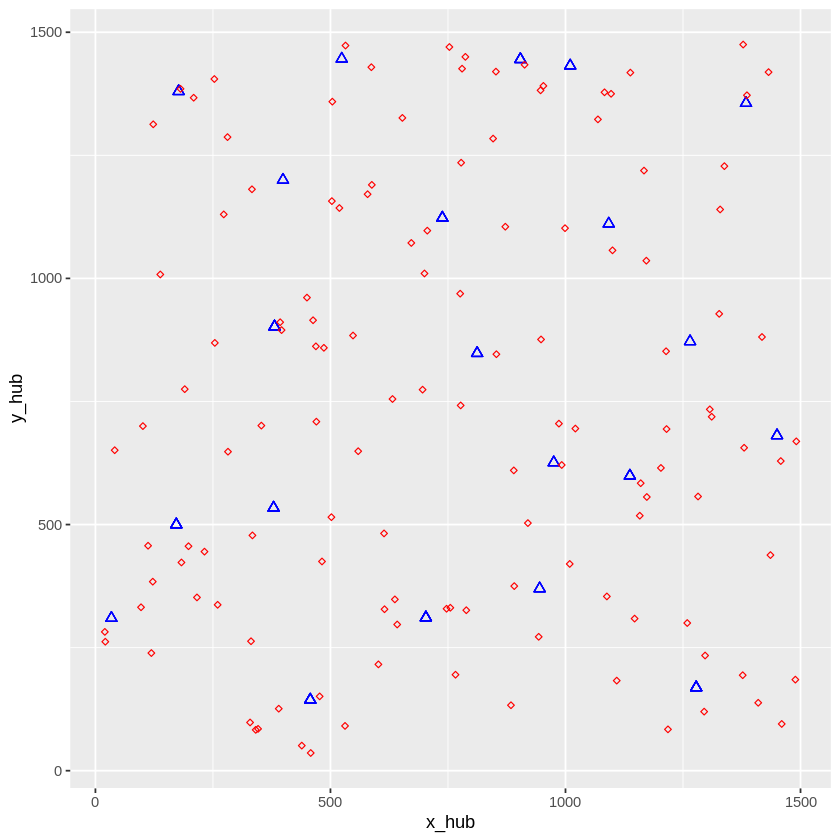

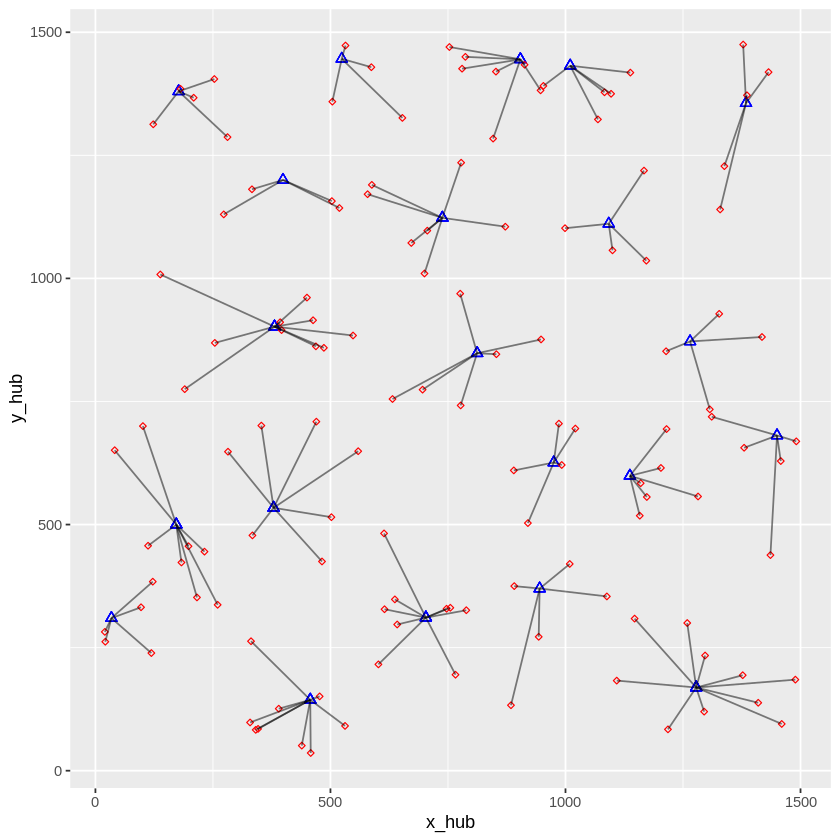

In [70]:
final %>%
  ggplot() +
  geom_point(aes(x_hub,y_hub),color = "blue",shape = 2,size = 2) +
  geom_point(aes(x_cust,y_cust),color = "red",shape = 5,size = 1)
  
final %>%
  ggplot() +
  geom_point(aes(x_hub,y_hub),color = "blue",shape = 2,size = 2) +
  geom_point(aes(x_cust,y_cust),color = "red",shape = 5,size = 1) +
  geom_segment(aes(x = x_hub,
                   y = y_hub,
                   xend = x_cust,
                   yend = y_cust),
                   alpha = .5
              )
  

In [71]:
final %>%
    arrange(hub_id,cust_id) %>%
    mutate(jarak = sqrt((x_hub-x_cust)^2 + (y_hub-y_cust)^2),
           jarak = round(jarak,2)) %>%
    group_by(hub_id) %>%
    summarise(n_cust = n(),
              cost = mean(cost_setup),
              total_jarak = sum(jarak)) %>%
    ungroup()

`summarise()` ungrouping output (override with `.groups` argument)



hub_id,n_cust,cost,total_jarak
<int>,<int>,<dbl>,<dbl>
1,10,310,1209.15
5,4,360,389.17
8,5,400,557.16
12,6,400,757.97
14,9,410,950.41
15,5,320,517.72
17,4,380,458.21
19,9,450,881.86
20,7,360,1075.81
